In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restraunt-reviews-for-absa/test_no_annotations.xml
/kaggle/input/restraunt-reviews-for-absa/train.xml


# Using BERT for Aspect Based Sentiment Analysis (ABSA)

## Installing Dependencies

In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses --quiet
!pip install transformers --quiet

## Imports

In [3]:
from tqdm.auto import tqdm
from time import perf_counter

import xml.etree.ElementTree as ET
from xml.dom import minidom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import transformers
from transformers import BertModel, BertTokenizer, get_scheduler, set_seed

## Configuration Class for our model

In [4]:
# CONFIGURATION CLASS
@dataclass
class Config:
    data_path: str = "../input/restraunt-reviews-for-absa/train.xml"
    test_path: str = "../input/restraunt-reviews-for-absa/test_no_annotations.xml"
    output_path: str = "./test.xml"
    batch_size: int = 16
    val_size: int = 500 
    train_size: int = 0
    pin_memory: bool = True
    num_workers: int = 2
    seed: int = 42
    lr: float = 5e-5

In [5]:
config = Config()

In [6]:
set_seed(config.seed)

## Preprocessing Data

In [7]:
# @author: Pulkit
def readData(path):
    root = ET.parse(path).getroot()
    dataset = []
    for i in root:
        row = []
        for j in i:
            if j.tag == "text":
                row.append(j.text)
            else:
                for k in j:
                    row.append(k.attrib.get("category"))
                    row.append(k.attrib.get("polarity"))
                    dataset.append(row)
    return dataset

def GenerateAspectCategoriesDict(df):
    aspectCategories = np.array(df[1])
    aspectCategories = np.concatenate((aspectCategories, np.array(df[3])))
    aspectCategories = np.concatenate((aspectCategories, np.array(df[5])))
    aspectCategories = np.concatenate((aspectCategories, np.array(df[7])))
    aspectCategories = np.concatenate((aspectCategories, np.array(df[9])))
    aspectCategories = aspectCategories[aspectCategories != None]
    aspectCategories = np.unique(aspectCategories)

    aspectCategoriesDictIdxToCat = dict(enumerate(aspectCategories))
    aspectCategoriesDictCatToIdx = {}
    for i, j in enumerate(aspectCategories):
        aspectCategoriesDictCatToIdx[j] = i

    return aspectCategoriesDictCatToIdx, aspectCategoriesDictIdxToCat

def PolarityDict():
    polarityDictPolToIdx = {}
    polarityDictIdxToPol = {}
    polarity = ["positive", "neutral", "negative"]
    for i, j in enumerate(polarity):
        polarityDictPolToIdx[j] = i
        polarityDictIdxToPol[i] = j
    return polarityDictPolToIdx, polarityDictIdxToPol

def GenerateAspectPolarityVector(df):
    data = np.array(df)
    aspectDictCatToIdx, aspectDictIdxToCat = GenerateAspectCategoriesDict(df)
    print(aspectDictCatToIdx)
    polarityDictCatToIdx, polarityDictIdxToCat = PolarityDict()

    categoryVec = []
    for i in range(len(df)):
        vec = [0 for k in range(24)]
        for j in range(1, 10, 2):
            if data[i][j] == None:
                break
            temp1 = aspectDictCatToIdx[data[i][j]]
            temp2 = polarityDictCatToIdx[data[i][j+1]]
            vec[(temp1*3)+temp2] = 1
        categoryVec.append(vec)
    
    return categoryVec

In [8]:
df = pd.DataFrame(readData(config.data_path))
df["Aspect"] = GenerateAspectPolarityVector(df)
# df.head(10)

# @author: Satwik
columns = ['reviews', 'aspect1', 'sentiment1', 'aspect2', 'sentiment2', 
           'aspect3', 'sentiment3', 'aspect4', 'sentiment4', 'aspect5', 
           'sentiment5', 'one_hot']

df.columns = columns
# df.head(10)

{'ambience': 0, 'food': 1, 'menu': 2, 'miscellaneous': 3, 'place': 4, 'price': 5, 'service': 6, 'staff': 7}


In [9]:
df.head()

,reviews,aspect1,sentiment1,aspect2,sentiment2,aspect3,sentiment3,aspect4,sentiment4,aspect5,sentiment5,one_hot
0,It might be the best sit down food I've had in...,food,positive,place,neutral,None,None,None,None,None,None,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,It might be the best sit down food I've had in...,food,positive,place,neutral,None,None,None,None,None,None,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,Hostess was extremely accommodating when we ar...,staff,positive,miscellaneous,neutral,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,Hostess was extremely accommodating when we ar...,staff,positive,miscellaneous,neutral,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,We were a couple of minutes late for our reser...,miscellaneous,neutral,staff,negative,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."


In [10]:
aspect_conversion_dict = {'ambience': 0, 'food': 1, 'menu': 2, 'miscellaneous': 3, 'place': 4, 'price': 5, 'service': 6, 'staff': 7}
sentiment_conversion_dict = {'positive': 2, 'neutral': 1, 'negative': 0}

df['aspect1'] = df['aspect1'].apply(lambda x: aspect_conversion_dict[x])
df['sentiment1'] = df['sentiment1'].apply(lambda x: sentiment_conversion_dict[x])

df['aspect2'] = df['aspect2'].apply(lambda x: aspect_conversion_dict[x])
df['sentiment2'] = df['sentiment2'].apply(lambda x: sentiment_conversion_dict[x])

# df['aspect3'] = df['aspect3'].apply(lambda x: aspect_conversion_dict[x] if x is not None)
# df['sentiment3'] = df['sentiment3'].apply(lambda x: sentiment_conversion_dict[x] if x is not None)

# df['aspect4'] = df['aspect4'].apply(lambda x: aspect_conversion_dict[x] if x is not None)
# df['sentiment4'] = df['sentiment4'].apply(lambda x: sentiment_conversion_dict[x] if x is not None)

# df['aspect5'] = df['aspect5'].apply(lambda x: aspect_conversion_dict[x] if x is not None)
# df['sentiment5'] = df['sentiment5'].apply(lambda x: sentiment_conversion_dict[x] if x is not None)

In [11]:
a1 = df['aspect1']
s1 = df['sentiment1']
a1 += 1
s1 += 1
df['labels1'] = a1*s1 - 1

a2 = df['aspect2']
s2 = df['sentiment2']
a2 += 1
s2 += 1
df['labels2'] = a2*s2 - 1

df.head()

,reviews,aspect1,sentiment1,aspect2,sentiment2,aspect3,sentiment3,aspect4,sentiment4,aspect5,sentiment5,one_hot,labels1,labels2
0,It might be the best sit down food I've had in...,2,3,5,2,None,None,None,None,None,None,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5,9
1,It might be the best sit down food I've had in...,2,3,5,2,None,None,None,None,None,None,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5,9
2,Hostess was extremely accommodating when we ar...,8,3,4,2,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",23,7
3,Hostess was extremely accommodating when we ar...,8,3,4,2,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",23,7
4,We were a couple of minutes late for our reser...,4,2,8,1,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",7,7


In [12]:
# def combine_aspect_sentiments(df, aspect_col, sentiment_col):
#     a = df[aspect_col]
#     s = df[sentiment_col]
#     ohl = int(a*s)

In [13]:
# df.head()

## Model Preparation

In [14]:
classifier = nn.Sequential(nn.Dropout(), nn.Linear(768, 24), nn.ReLU())
classifer2 = nn.Sequential(nn.Dropout(), nn.Linear(768, 24), nn.ReLU())

In [15]:
class BertForABSA(nn.Module):
    def __init__(self, bert, num_labels=24):
        super(BertForABSA, self).__init__()
        self.bert = bert
        self.classifier = classifier
#         self.dropout = nn.Dropout()
#         self.classifier = nn.Linear(768, num_labels)
#         self.relu = nn.ReLU()

    def forward(self, input_ids, token_type_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, 
                                     return_dict=False)
        
        logits = self.classifier(pooled_output)
#         pooled_output = self.dropout(pooled_output)
#         logits = self.classifier(pooled_output)
#         logits = self.relu(logits)

        return logits

## Dataset and DataLoaders

In [16]:
class ReviewsDataset(Dataset):
    def __init__(self, train_data, tokenizer, label_col, max_sequence_len=96, as_float=False): 
        self.as_float = as_float
        print("Starting Process ...")   
        labels = list(train_data[label_col].values)
        # Number of exmaples.
        self.n_examples = len(labels)
        # Use tokenizer on texts. This can take a while.
        print('Using tokenizer on all texts ...')

        texts = list(train_data['reviews'].values)
        self.inputs = tokenizer(texts, add_special_tokens=True, \
                                truncation=True, padding=True, \
                                return_tensors='pt')
        
        # Get maximum sequence length.
        self.sequence_len = self.inputs['input_ids'].shape[-1]
        print('Texts padded or truncated to %d length!' % self.sequence_len)
        # Add labels.
        self.labels = torch.tensor(labels)
        print('Finished!\n')
 
    def __len__(self):
        return self.n_examples
 
    def __getitem__(self, i):
        if self.as_float:
            return {key: self.inputs[key][i] for key in self.inputs.keys()}, self.labels[i].to(torch.float)
        else:
            return {key: self.inputs[key][i] for key in self.inputs.keys()}, self.labels[i]

In [17]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
dataset = ReviewsDataset(df, tokenizer, 'labels1')

Starting Process ...
Using tokenizer on all texts ...
Texts padded or truncated to 97 length!
Finished!



In [19]:
inputs, labels = dataset[0]
print(inputs, labels) 

{'input_ids': tensor([  101,  2009,  2453,  2022,  1996,  2190,  4133,  2091,  2833,  1045,
         1005,  2310,  2018,  1999,  1996,  2181,  1010,  2061,  2065,  2017,
         2024,  2183,  2000,  1996, 10051,  6926,  4250,  1010,  2030,  1996,
         3871,  1010,  2009,  2071,  2022,  2074,  1996,  2173,  2005,  2017,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
config.train_size = len(dataset) - config.val_size
train_ds, val_ds = random_split(dataset, [config.train_size, config.val_size])

In [21]:
train_loader = DataLoader(train_ds, config.batch_size, shuffle=True,
                          num_workers=config.num_workers, 
                          pin_memory=config.pin_memory)


val_loader = DataLoader(val_ds, config.batch_size, shuffle=False, 
                        num_workers=config.num_workers, 
                        pin_memory=config.pin_memory)

In [22]:
for input, label in train_loader:
    print(input)
    print()
    print(label)
    break

{'input_ids': tensor([[ 101, 1996, 8241,  ...,    0,    0,    0],
        [ 101, 2079, 2025,  ...,    0,    0,    0],
        [ 101, 2096, 2057,  ...,    0,    0,    0],
        ...,
        [ 101, 2009, 2165,  ...,    0,    0,    0],
        [ 101, 6980, 3561,  ...,    0,    0,    0],
        [ 101, 4593, 1010,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

tensor([23,  1,  3,  7,  7, 20,  8,  7, 23,  3,  2,  5,  7,  9,  3,  7])


In [23]:
def get_one_hot(outputs, k=2):
    outputs = outputs.detach()
    x = torch.topk(outputs, k)
    for i, t in enumerate(outputs):
#         x = torch.topk(t, k[i])
        for j, _ in enumerate(t):
            if j in x.indices[i]:
                t[j] = 1
            else:
                t[j] = 0
            outputs[i] = t

    outputs.requires_grad = True
    return outputs.to(torch.float)

def get_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).sum()

def one_hot_acc(one_hot_outputs, labels):
    result = torch.all(one_hot_outputs.eq(labels))
    return result.sum()

In [24]:
model = BertForABSA(bert)

## Training our Model(s)

In [25]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs):
    # track the time and history
    start = perf_counter()
    history = []
    # check for cuda use
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        torch.cuda.empty_cache()
    
    # prepare optimizer, loss-criterion and lr-scheduler
#     criterion = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, 
                                 num_warmup_steps=0, 
                                 num_training_steps=num_training_steps)
    
    # prepare a progress bar
    progress_bar = tqdm(range(num_training_steps))
    
    # move model to the GPU
    if use_cuda:
            # linear = linear.cuda()
            model = model.cuda()
            criterion = criterion.cuda()
    
    # Start Epoch wise training
    for epoch_num in range(epochs):
        epoch_start = perf_counter()
        total_acc_train = 0
        total_loss_train = 0
        
        # Training Phase
        model.train()
        for inputs, label in train_dataloader:
            label = label.to(torch.long)
            label = label.to(device)
            # label = torch.argmax(label, dim=1)
            
            inputs['attention_mask'] = inputs['attention_mask'].to(device)
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['token_type_ids'] = inputs['token_type_ids'].to(device)

            outputs = model(**inputs)
            ## k = label.sum(dim=1).to(torch.int)
            ## assert len(k) == config.batch_size
#           ##  one_hot_outputs = get_one_hot(outputs)       
            
            # loss calculation step 
            batch_loss = criterion(outputs, label)
            # batch_loss = criterion(one_hot_outputs, label)
            batch_loss.backward()
            
            # collate losses and acc.
            total_loss_train += batch_loss.item()
            acc = get_accuracy(outputs, label)
            # acc = one_hot_acc(one_hot_outputs, label)
            total_acc_train += acc
            
            # Update step
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        # Validation Phase
        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(torch.long)
                val_label = val_label.to(device)
#                 val_label = torch.argmax(val_label, dim=1)

                val_input['attention_mask'] = val_input['attention_mask'].to(device)
                val_input['input_ids'] = val_input['input_ids'].to(device)
                val_input['token_type_ids'] = val_input['token_type_ids'].to(device)

                outputs = model(**val_input)
#                 k = label.sum(dim=1).to(torch.int)
#                 assert len(k) == config.batch_size
#                 one_hot_outputs = get_one_hot(outputs)       

                batch_loss = criterion(outputs, val_label)
#                 batch_loss = criterion(one_hot_outputs, val_label)
                total_loss_val += batch_loss.item()
                
                acc = get_accuracy(outputs, val_label)
#                 acc = one_hot_acc(one_hot_outputs, label)
                total_acc_val += acc
        
        # measure epoch-time        
        epoch_time = perf_counter() - epoch_start
        
        # print results
        print(f'\nEpochs: {epoch_num + 1}/{epochs} | Train Loss: {total_loss_train / len(train_ds): .3f} \
| Train Accuracy: {total_acc_train / len(train_ds): .3f} | Val Loss: {total_loss_val / len(val_ds): .3f} \
| Val Accuracy: {total_acc_val / len(val_ds): .3f} | Epoch Time: {epoch_time//60:.0f}m {epoch_time%60:.2f}s')
        
        # store results
        result = {'epoch': epoch_num + 1, 
                  'train_loss': total_loss_train / len(train_ds),
                  'train_acc': total_acc_train / len(train_ds),
                  'val_loss': total_loss_val / len(val_ds),
                  'val_acc': total_acc_val / len(val_ds),
                  'epoch_time': epoch_time
                 }
        history.append(result)
    
    time_taken = perf_counter() - start
    print(f"\nTime Taken to train the model: {time_taken//60:.0f}m {time_taken%60:.2f}s")
    
    return history

In [26]:
def train_together(model, train_dataloader, val_dataloader, learning_rate, epochs):
    # track the time and history
    start = perf_counter()
    history = []
    # check for cuda use
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        torch.cuda.empty_cache()
    
    # prepare optimizer, loss-criterion and lr-scheduler
    criterion = nn.BCELoss()
#     criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, 
                                 num_warmup_steps=0, 
                                 num_training_steps=num_training_steps)
    
    # prepare a progress bar
    progress_bar = tqdm(range(num_training_steps))
    
    # move model to the GPU
    if use_cuda:
            # linear = linear.cuda()
            model = model.cuda()
            criterion = criterion.cuda()
    
    # Start Epoch wise training
    for epoch_num in range(epochs):
        epoch_start = perf_counter()
        total_acc_train = 0
        total_loss_train = 0
        
        # Training Phase
        model.train()
        for inputs, label in train_dataloader:
#             label = label.to(torch.long)
            label = label.to(device)
            # label = torch.argmax(label, dim=1)
            
            inputs['attention_mask'] = inputs['attention_mask'].to(device)
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['token_type_ids'] = inputs['token_type_ids'].to(device)

            outputs = model(**inputs)
            ## k = label.sum(dim=1).to(torch.int)
            ## assert len(k) == config.batch_size
            one_hot_outputs = get_one_hot(outputs)       
            
            # loss calculation step 
#             batch_loss = criterion(outputs, label)
            batch_loss = criterion(one_hot_outputs, label)
            batch_loss.backward()
            
            # collate losses and acc.
            total_loss_train += batch_loss.item()
#             acc = get_accuracy(outputs, label)
            try:
                acc = one_hot_acc(one_hot_outputs, label)
            except:
                acc = 0
            total_acc_train += acc
            
            # Update step
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        # Validation Phase
        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
#                 val_label = val_label.to(torch.long)
                val_label = val_label.to(device)
#                 val_label = torch.argmax(val_label, dim=1)

                val_input['attention_mask'] = val_input['attention_mask'].to(device)
                val_input['input_ids'] = val_input['input_ids'].to(device)
                val_input['token_type_ids'] = val_input['token_type_ids'].to(device)

                outputs = model(**val_input)
#                 k = label.sum(dim=1).to(torch.int)
#                 assert len(k) == config.batch_size
                one_hot_outputs = get_one_hot(outputs)       

#                 batch_loss = criterion(outputs, val_label)
                batch_loss = criterion(one_hot_outputs, val_label)
                total_loss_val += batch_loss.item()
                
#                 acc = get_accuracy(outputs, val_label)
                try:
                    acc = one_hot_acc(one_hot_outputs, label)
                except:
                    acc = 0
                total_acc_val += acc
        
        # measure epoch-time        
        epoch_time = perf_counter() - epoch_start
        
        # print results
        print(f'\nEpochs: {epoch_num + 1}/{epochs} | Train Loss: {total_loss_train / len(train_ds): .3f} \
| Train Accuracy: {total_acc_train / len(train_ds): .3f} | Val Loss: {total_loss_val / len(val_ds): .3f} \
| Val Accuracy: {total_acc_val / len(val_ds): .3f} | Epoch Time: {epoch_time//60:.0f}m {epoch_time%60:.2f}s')
        
        # store results
        result = {'epoch': epoch_num + 1, 
                  'train_loss': total_loss_train / len(train_ds),
                  'train_acc': total_acc_train / len(train_ds),
                  'val_loss': total_loss_val / len(val_ds),
                  'val_acc': total_acc_val / len(val_ds),
                  'epoch_time': epoch_time
                 }
        history.append(result)
    
    time_taken = perf_counter() - start
    print(f"\nTime Taken to train the model: {time_taken//60:.0f}m {time_taken%60:.2f}s")
    
    return history

### Training 1st model for 1st AE and ASC

In [27]:
history = train(model, train_loader, val_loader, 5e-5, 5)

  0%|          | 0/2050 [00:00<?, ?it/s]


Epochs: 1/5 | Train Loss:  0.125 | Train Accuracy:  0.451 | Val Loss:  0.077 | Val Accuracy:  0.668 | Epoch Time: 1m 13.01s

Epochs: 2/5 | Train Loss:  0.056 | Train Accuracy:  0.769 | Val Loss:  0.038 | Val Accuracy:  0.868 | Epoch Time: 1m 12.32s

Epochs: 3/5 | Train Loss:  0.022 | Train Accuracy:  0.921 | Val Loss:  0.018 | Val Accuracy:  0.942 | Epoch Time: 1m 12.99s

Epochs: 4/5 | Train Loss:  0.010 | Train Accuracy:  0.976 | Val Loss:  0.012 | Val Accuracy:  0.962 | Epoch Time: 1m 12.22s

Epochs: 5/5 | Train Loss:  0.006 | Train Accuracy:  0.989 | Val Loss:  0.010 | Val Accuracy:  0.972 | Epoch Time: 1m 12.36s

Time Taken to train the model: 6m 3.07s


### Training 2nd model for 2nd AE and ASC

In [28]:
df.head()

,reviews,aspect1,sentiment1,aspect2,sentiment2,aspect3,sentiment3,aspect4,sentiment4,aspect5,sentiment5,one_hot,labels1,labels2
0,It might be the best sit down food I've had in...,2,3,5,2,None,None,None,None,None,None,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5,9
1,It might be the best sit down food I've had in...,2,3,5,2,None,None,None,None,None,None,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5,9
2,Hostess was extremely accommodating when we ar...,8,3,4,2,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",23,7
3,Hostess was extremely accommodating when we ar...,8,3,4,2,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",23,7
4,We were a couple of minutes late for our reser...,4,2,8,1,None,None,None,None,None,None,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",7,7


In [29]:
dataset2 = ReviewsDataset(df, tokenizer, label_col='labels2')
train_ds2, val_ds2 = random_split(dataset2, [config.train_size, config.val_size])

Starting Process ...
Using tokenizer on all texts ...
Texts padded or truncated to 97 length!
Finished!



In [30]:
i, l = train_ds2[0]
print(l)

tensor(3)


In [31]:
train_loader2 = DataLoader(train_ds2, config.batch_size, shuffle=True,
                          num_workers=config.num_workers, 
                          pin_memory=config.pin_memory)


val_loader2 = DataLoader(val_ds2, config.batch_size, shuffle=False, 
                        num_workers=config.num_workers, 
                        pin_memory=config.pin_memory)

In [32]:
bert2 = BertModel.from_pretrained("bert-base-uncased")
model2 = BertForABSA(bert2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
history2 = train(model2, train_loader2, val_loader2, 5e-5, 5)

  0%|          | 0/2050 [00:00<?, ?it/s]


Epochs: 1/5 | Train Loss:  0.141 | Train Accuracy:  0.351 | Val Loss:  0.113 | Val Accuracy:  0.506 | Epoch Time: 1m 12.44s

Epochs: 2/5 | Train Loss:  0.081 | Train Accuracy:  0.635 | Val Loss:  0.061 | Val Accuracy:  0.722 | Epoch Time: 1m 12.72s

Epochs: 3/5 | Train Loss:  0.031 | Train Accuracy:  0.870 | Val Loss:  0.024 | Val Accuracy:  0.906 | Epoch Time: 1m 12.40s

Epochs: 4/5 | Train Loss:  0.011 | Train Accuracy:  0.970 | Val Loss:  0.014 | Val Accuracy:  0.946 | Epoch Time: 1m 12.22s

Epochs: 5/5 | Train Loss:  0.005 | Train Accuracy:  0.991 | Val Loss:  0.012 | Val Accuracy:  0.954 | Epoch Time: 1m 12.17s

Time Taken to train the model: 6m 2.20s


### Training Together

In [34]:
# df.head()

In [35]:
# dataset3 = ReviewsDataset(df, tokenizer, 'one_hot', as_float=True)
# train_ds3, val_ds3 = random_split(dataset3, [config.train_size, config.val_size])

In [36]:
# list(df['one_hot'].values)[0]

In [37]:
# i, l = train_ds3[0]
# print(l)

In [38]:
# train_loader3 = DataLoader(train_ds3, config.batch_size, shuffle=True,
#                           num_workers=config.num_workers, 
#                           pin_memory=config.pin_memory)


# val_loader3 = DataLoader(val_ds3, config.batch_size, shuffle=False, 
#                         num_workers=config.num_workers, 
#                         pin_memory=config.pin_memory)

In [39]:
# bert3 = BertModel.from_pretrained("bert-base-uncased")
# model3 = BertForABSA(bert3)

In [40]:
# for i, l in train_loader3:
#     print(l)
#     break

In [41]:
# history3 = train_together(model3, train_loader3, val_loader3, 5e-5, 5)

## Prediction

In [42]:
def predict(sentence):
    inputs = tokenizer(sentence, add_special_tokens=True, \
                                truncation=True, padding=True, \
                                return_tensors='pt')
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    output1 = model(**inputs)
    preds1 = torch.argmax(output1, dim=1)
    
    output2 = model2(**inputs)
    preds2 = torch.argmax(output2, dim=1)
    
    a1 = preds1.item()//3
    s1 = preds1.item()%3
    
    a2 = preds2.item()//3
    s2 = preds2.item()%3
    
    aspect_conversion_dict = {0: 'ambience', 1: 'food', 2: 'menu', 3: 'miscellaneous', 4: 'place', 5: 'price', 6: 'service', 7: 'staff'}
    sentiment_conversion_dict = {2: 'positive', 1: 'neutral', 0: 'negative'}
    
    aspect1 = aspect_conversion_dict[a1]
    sentiment1 = sentiment_conversion_dict[s1]
    
    aspect2 = aspect_conversion_dict[a2]
    sentiment2 = sentiment_conversion_dict[s2]
    
    prediction = {aspect1: sentiment1, aspect2: sentiment2}
    
    return prediction #, a1, a2, s1, s2

In [43]:
# def predict_together(sentence):
#     inputs = tokenizer(sentence, add_special_tokens=True, \
#                                 truncation=True, padding=True, \
#                                 return_tensors='pt')
    
#     use_cuda = torch.cuda.is_available()
#     device = torch.device("cuda" if use_cuda else "cpu")
#     inputs = {k: v.to(device) for k, v in inputs.items()}
    
#     outputs = model(**inputs)
#     oh = get_one_hot(outputs)


In [44]:
sentence = "Only quibbles are so-so wine service, and while Prix-fixe is reasonable at $68, extra charges for additional dishes/tastings can be high."
# inputs = tokenizer(sentence)
# print(inputs)
prediction = predict(sentence)
print(prediction)

{'menu': 'negative', 'miscellaneous': 'positive'}


In [45]:
test_df = pd.read_xml(config.test_path)
test_df.head()

,text
0,"Overall, it is a nice place and if you don't m..."
1,"We waited 15 minutes for a menu, another 20 fo..."
2,the dishes are a little too recherche and too ...
3,The pricing isn't quite clear and look out for...
4,"the menu looked great, but the food was the bi..."


In [46]:
sents_aspects = test_df['text'].apply(predict)

In [47]:
# APPEND ASPECTS AND POLARITIES IN THE TEST DATAFRAME
aspect1 = []
aspect2 = []
sentiment1 = []
sentiment2 = []
for result in sents_aspects:
    aspects = list(result.keys())
    sentiments = list(result.values())
    
    aspect1.append(aspects[0])
    if len(aspects) == 2:
        aspect2.append(aspects[1])
    else:
        aspect2.append(None)
        
    sentiment1.append(sentiments[0])
    if len(sentiments) == 2:
        sentiment2.append(sentiments[1])
    else:
        sentiment2.append(None)

In [48]:
test_df['aspect1'] = aspect1
test_df['sentiment1'] = sentiment1
test_df['aspect2'] = aspect2
test_df['sentiment2'] = sentiment2

In [49]:
test_df

,text,aspect1,sentiment1,aspect2,sentiment2
0,"Overall, it is a nice place and if you don't m...",place,positive,food,positive
1,"We waited 15 minutes for a menu, another 20 fo...",food,positive,menu,neutral
2,the dishes are a little too recherche and too ...,food,positive,None,None
3,The pricing isn't quite clear and look out for...,food,positive,None,None
4,"the menu looked great, but the food was the bi...",menu,positive,food,positive
5,My boyfriend and I went one Friday night to fi...,food,neutral,None,None
6,The Pink Pony's brunch is among the very best ...,food,positive,miscellaneous,positive
7,The environment is a touch loud (although the ...,ambience,negative,place,positive
8,"Only quibbles are so-so wine service, and whil...",menu,negative,miscellaneous,positive
9,Our waiter was a real pro; knew a lot about in...,staff,positive,ambience,neutral


### Saving Result to XML file

In [50]:
root = minidom.Document()
sentences = root.createElement('sentences')

for text, aspect1, sentiment1, aspect2, sentiment2 in zip(test_df['text'], test_df['aspect1'], test_df['sentiment1'], test_df['aspect2'], test_df['sentiment2']):
    sentence = root.createElement('sentence')
    text_child = root.createElement('text')
    text_child.appendChild(root.createTextNode(text))
    
    aspect_cats_child = root.createElement('aspectCategories')
    
    aspect_cat_child1 = root.createElement('aspectCategory')
    aspect_cat_child1.setAttribute('category', aspect1)
    aspect_cat_child1.setAttribute('polarity', sentiment1)    

    aspect_cat_child2 = root.createElement('aspectCategory')
    aspect_cat_child2.setAttribute('category', aspect2)
    aspect_cat_child2.setAttribute('polarity', sentiment2)
    
    aspect_cats_child.appendChild(aspect_cat_child1)
    aspect_cats_child.appendChild(aspect_cat_child2)
    sentence.appendChild(text_child)
    sentence.appendChild(aspect_cats_child)
    
    sentences.appendChild(sentence)


root.appendChild(sentences)
test_xml = root.toprettyxml(indent ="\t") 

with open(config.output_path, "w") as f:
    f.write(test_xml) 

## Plotting Results

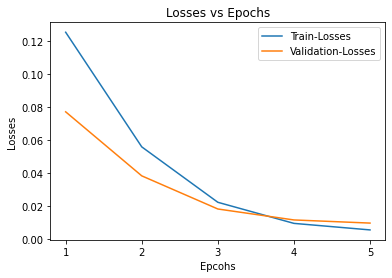

In [51]:
train_losses = [x['train_loss'] for x in history]
val_losses = [x['val_loss'] for x in history]
epochs = [x['epoch'] for x in history]

plt.locator_params(axis='x', nbins=5)
plt.plot(epochs, train_losses, label='Train-Losses')
plt.plot(epochs, val_losses, label='Validation-Losses')
plt.xlabel('Epcohs')
plt.ylabel('Losses')
plt.title('Losses vs Epochs')
plt.legend()

# print(train_loss)

In [52]:
def plot(history, name="HistoryPlot", figsize=(20, 9)):
    fig = plt.figure(figsize=figsize)
    epochs = [x['epoch'] for x in history]
    
    # Plotting Losses
    ax1 = fig.add_subplot(121)
    ax1.locator_params(axis='x', nbins=5)    
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax1.plot(epochs, train_losses, label='Train-Losses')
    ax1.plot(epochs, val_losses, label='Validation-Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Losses vs Epochs')
    plt.legend()
    
    # Plotting Accuracies
    ax2 = fig.add_subplot(122)
    ax2.locator_params(axis='x', nbins=5)    
    train_accs = [x['train_acc'].cpu() for x in history]
    val_accs = [x['val_acc'].cpu() for x in history]
    ax2.plot(epochs, train_accs, label='Train-Accuracies')
    ax2.plot(epochs, val_accs, label='Validation-Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')
    plt.title('Accuracies vs Epochs')
    plt.legend()
    
    fig.savefig('./'+name+".jpg")
    plt.show()

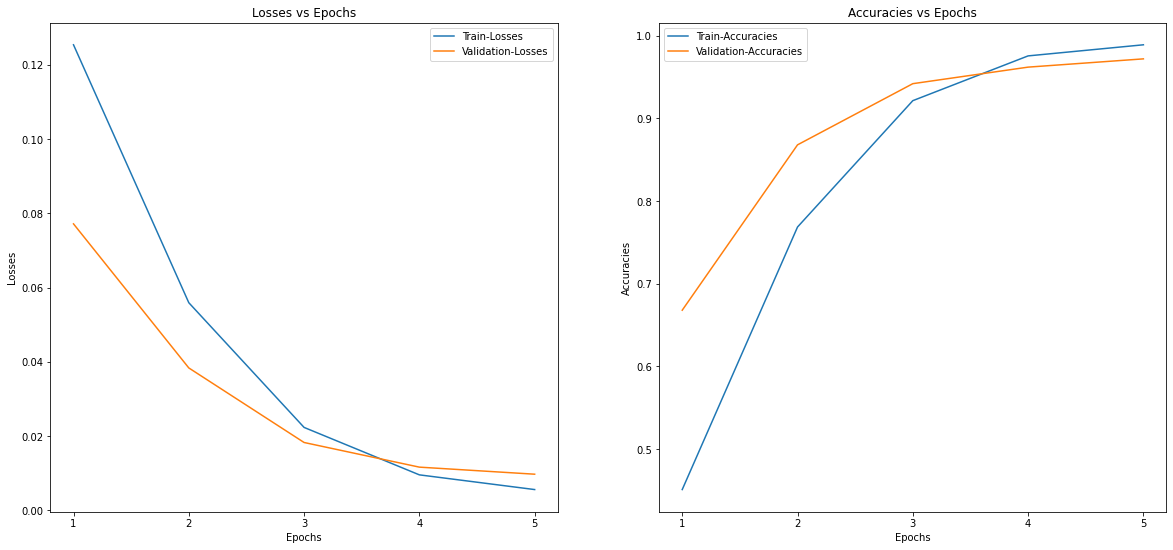

In [53]:
plot(history, name="HistoryPlot1")

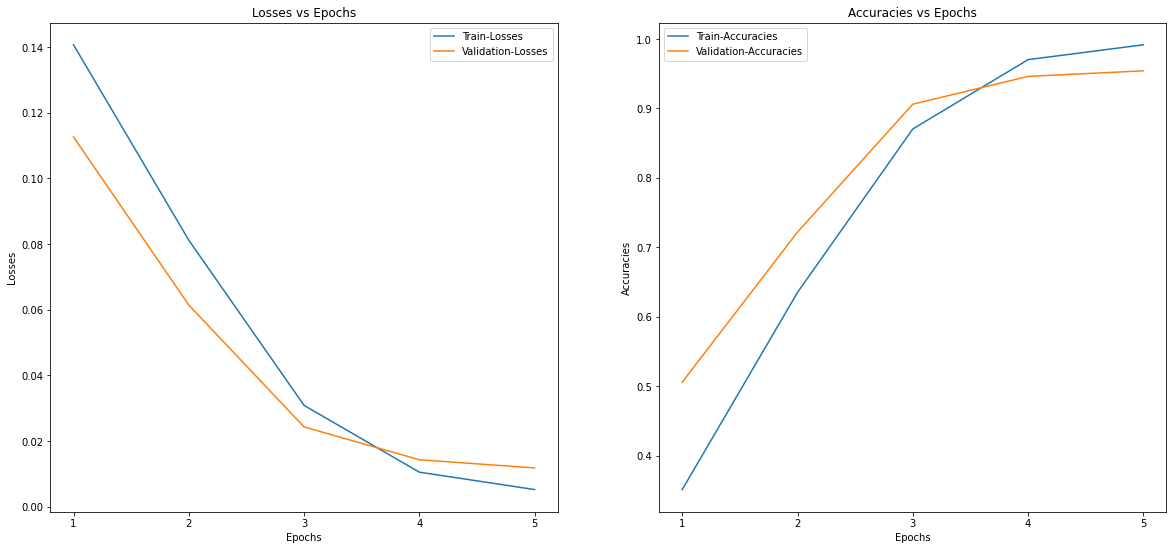

In [54]:
plot(history2, name="HistoryPlot2")

## Save Model

In [55]:
import os
os.mkdir('./models')
torch.save(model.state_dict(), './models/model1.pt')
torch.save(model2.state_dict(), './models/model2.pt')